# Solar system use case notebook

José Peña & Francisco Förster

ALeRCE starter notebook for asteroid science.

In this notebook you will connect to the ALeRCE database, download asteroid candidates, and plot their trajectories. 

You will plot their spatial distribution using datashader aggregation.

Will install first the ALeRCE client.

In [1]:
!pip install alerce

### Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime

In [3]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis

Install psycopg2 https://github.com/psycopg/psycopg2

In [4]:
#!pip install psycopg2-binary
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
from alerce.core import Alerce
client = Alerce()

### Get credentials (in github repository)

In [7]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

### Connect to DB

In [8]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

The DB contains the following tables, among others:
    
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS object as reported by ZTF
* `ss_ztf`: closest MPC object as reported by ZTF
* `gaia_ztf`: closet GAIA source as reported by ZTF
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

### Show all the available tables

In [9]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


### For each table, show column names and column types

In [10]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


# Query objects

Query objects which appeared between March 1st 2021 and Apr 1st 2021, which have at most one detection, and which are classified as asteroids by the stamp classifier with a probability greater than 0.7

Objects can share the same `oid` (not the `candid`) if they appear at the same position. Asteroids move, so we choose those than appear only once (`ndet=1`).

The probability of being an asteroid is computed by the stamp classifier and is stored in the table `probability`, so we need to do an inner join with the table `object`.

This query takes about 90 s.

In [11]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

(106987, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqsog,167.004230,5.923218,59274.234097,1,0.713130
ZTF21aanqswo,160.281744,6.278048,59274.240544,1,0.701919
ZTF21aanqtff,169.347383,16.200741,59274.239144,1,0.709595
ZTF21aanrlcy,161.861841,-3.321902,59274.357072,1,0.732384
ZTF21aanrldc,161.508833,-3.442972,59274.357072,1,0.703184


# Check whether these objects are reported as known asteroids

Once we have all asteroids candidates, we wonder if some of them are known asteroids. So we go to table `ss_ztf` to look for our asteroids candidates using their `oid`.

Table `ss_ztf` gives data from the Minor Planet Center (MPC) of the nearest known body. If there is not a reported nearby SS object the table will contain a `ssdistnr` value of -999.

In [12]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

(106722, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF17aacjmvh,1549157311215015001,20.0,22.0,460597
1,ZTF17aadpaan,1549156852815015007,7.0,21.3,116078
2,ZTF17aaduwjp,1544177711915015090,18.0,21.7,485689
3,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
4,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263


We can see that most objects previously found were known to MPC.

# Plot distribution of separations for those objects with a xmatch in MPC

How many bodies are known asteroids?

How close is a detected body to the estimated nearest known body?

Text(0.5, 0, 'arcsec')

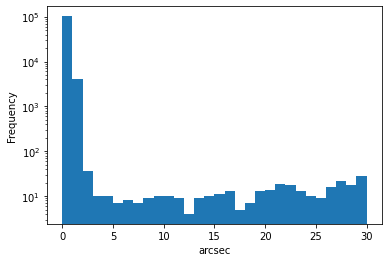

In [13]:
ax = ss.ssdistnr.plot.hist(bins=30, log=True)
ax.set_xlabel('arcsec')

There is  small tail (we are using log scale) going to large separations, probably poorly determined asteroid trajectories in MPC or detections that do not correspond to any known asteroid.

# Move to ecliptic coordinates

Using `astropy.coordinates.SkyCoord` is very easy to move from one coordinate system to another. But be careful: you might be including unnecesary corrections (light-travel time corrections, different origins, etc.)

We tell `astropy` to go from `icrs` to `barycentrictrueecliptic` (both barycentric) since it only applies a simple rotation (althoug we observe from the Earth, not the barycenter).

In [14]:
from astropy.coordinates import SkyCoord
eq = SkyCoord(ast['meanra'].values, ast['meandec'].values, unit='deg', frame='icrs')
ecl = eq.barycentrictrueecliptic

In [15]:
ast["ecl_lat"] = ecl.lat.deg
ast["ecl_long"] = ecl.lon.deg

# Plot histogram of ecliptic latitudes

Text(0, 0.5, 'N')

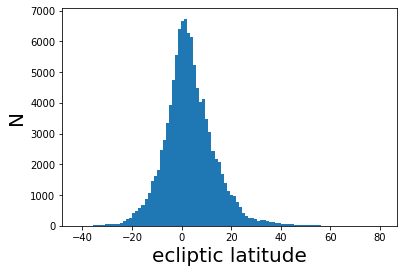

In [16]:
fig, ax = plt.subplots()
ax.hist(ast.ecl_lat, bins=100);
ax.set_xlabel("ecliptic latitude", fontsize=20)
ax.set_ylabel("N", fontsize=20)

Note that most selected objects are around the ecliptic. We will also look at the individual tracks in what follows.

# Plot ecliptic coordinates in the sky using datashader

Let's use datashader to plot the ecliptic coordinates of all the previous asteroids.

In [18]:
!pip install datashader
import datashader as ds

     |████████████████████████████████| 15.8MB 263kB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 112kB 44.3MB/s 
     |████████████████████████████████| 686kB 45.6MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=5f4c6dc926cbaf356fb94106bc6dccbeb2adb1aab8be5c8dd4ad7fcb137a7598
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built datashape
ERROR: distributed 2021.4.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.4.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


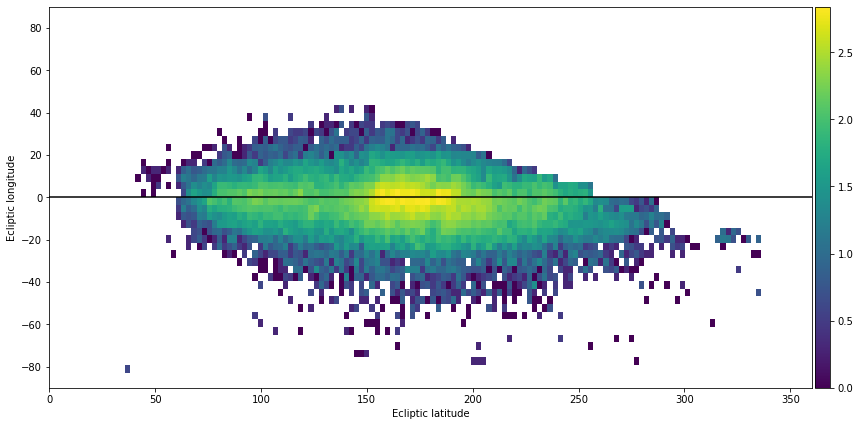

In [19]:
# do datashade aggregation
x_range = [0, 360]
y_range = [-90, 90]
cvs = ds.Canvas(plot_width=150, plot_height=50, x_range=x_range, y_range=y_range)
agg = cvs.points(ast, 'ecl_long', 'ecl_lat')

# show result
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(np.log10(agg), extent=x_range + y_range)
ax.set_xlabel("Ecliptic latitude")
ax.set_ylabel("Ecliptic longitude")
ax.axhline(0, c='k')

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

As expected, almost all asteroids are near the ecliptic plane. We cannot see the entire ecliptic in one month of data alone.

# Show the object with the largest number of detections

Lets look for a pretty example. Lets find the (known) asteroid with the most detections and see how it looks like.

In [77]:
ndet = ss.groupby("ssnamenr").apply(lambda df: df.shape[0])

Text(0.5, 0, 'Number of detections')

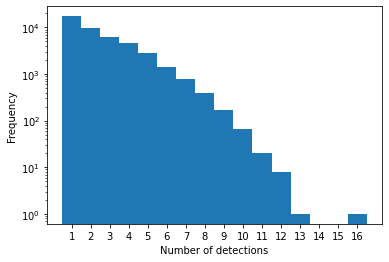

In [21]:
ax = ndet.plot.hist(log=True, bins=np.linspace(1,max(ndet)+1,max(ndet)+1)-.5)
ax.set_xticks(np.linspace(1,max(ndet),max(ndet)))
ax.set_xlabel('Number of detections')

`ndet` is a table with the amount of apparitions of each known asteroid.

In [22]:
ndet.head()

ssnamenr
10002     3
100028    1
10004     3
100040    3
100041    3
dtype: int64

# Plot the trajectories of all asteroids with at least 9 detections in equatorial and ecliptic coordinates

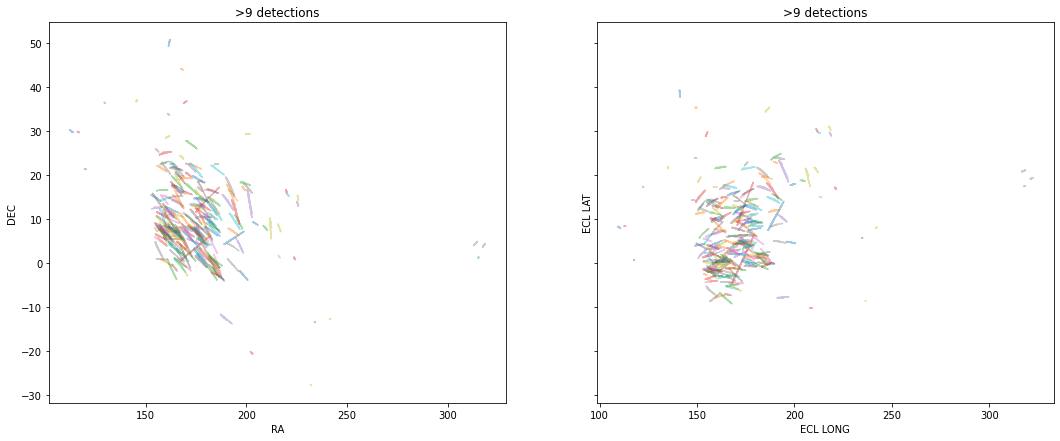

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7), sharey=True)
ndetmin = 9
for ssnamenr in ndet.loc[ndet>=ndetmin].index: # Getting the names of asteroids with at least 9 detections

  oids = ss.loc[ss.ssnamenr==ssnamenr].oid     # Getting the oids of the known asteroid in table 'ss'
  mask = ast.index.isin(oids)                  # Getting if oids in table 'ast' is in oids (from 'ss' of known bodies) 

  ax[0].plot(ast.loc[mask].meanra, ast.loc[mask].meandec, alpha=0.4)
  ax[0].set_title(">%i detections" % ndetmin); ax[0].set_xlabel("RA"); ax[0].set_ylabel("DEC")

  ax[1].plot(ast.loc[mask].ecl_long, ast.loc[mask].ecl_lat, alpha=0.4)
  ax[1].set_title(r">%i detections" % ndetmin); ax[1].set_xlabel("ECL LONG"); ax[1].set_ylabel("ECL LAT")

The trajectories in ecliptic coordinates look more horizontal, as expected.

# Focus on the asteroid with the most detections (*153935*)

In [24]:
bestast = ndet.idxmax()
print(bestast, ndet[bestast])

153935 16


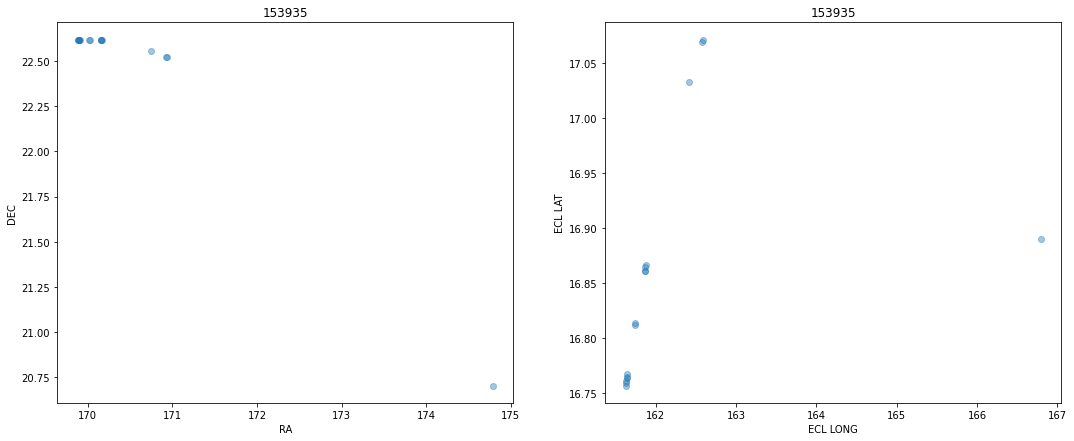

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
oids = ss.loc[ss.ssnamenr == bestast].oid
maskbest = ast.index.isin(oids)

ax[0].scatter(ast.loc[maskbest].meanra, ast.loc[maskbest].meandec, alpha=0.4)
ax[0].set_title(bestast); ax[0].set_xlabel("RA"); ax[0].set_ylabel("DEC")

ax[1].scatter(ast.loc[maskbest].ecl_long, ast.loc[maskbest].ecl_lat, alpha=0.4)
ax[1].set_title(bestast); ax[1].set_xlabel("ECL LONG"); ax[1].set_ylabel("ECL LAT")
plt.show()

Note that second panel is about ~0.3 deg tall and ~5 deg wide.

# Query and plot the light curve of *153935*

Magnitudes, colors and light curves give are important for asteroids' analysis. Having the `oid` of the detections we want (in this case, for the asteroid _153935_) we can get their magnitudes from table `detection` (we could also have used the table `magstat`).

In [28]:
query='''
SELECT oid, mjd, fid, magap, sigmagap, has_stamp
FROM detection
WHERE 
oid in (%s)
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in oids])

dets = pd.read_sql_query(query, conn)
print(dets.shape)
dets

(16, 6)


,oid,mjd,fid,magap,sigmagap,has_stamp
0,ZTF21aanzble,59276.257963,1,18.5545,0.0909,True
1,ZTF21aaqoxdu,59297.207396,1,18.4066,0.1152,True
2,ZTF21aaqpjvj,59297.258113,2,18.5211,0.1409,True
3,ZTF21aaqsnyf,59298.308194,2,18.0684,0.4209,True
4,ZTF21aaqyrqn,59303.279120,1,18.8896,0.2237,True
5,ZTF21aaqyzoj,59303.316192,2,18.6640,0.1742,True
6,ZTF21aarbeuz,59302.237153,2,18.6117,0.2218,True
7,ZTF21aarbleq,59302.263218,2,18.7135,0.2541,True
8,ZTF21aarcgki,59302.328241,1,18.7703,0.2773,True
9,ZTF21aarchtw,59302.332037,1,19.0693,0.3458,True


Plot the predicted light curve (by MPC) and compare it to the observed light curve in g and r bands

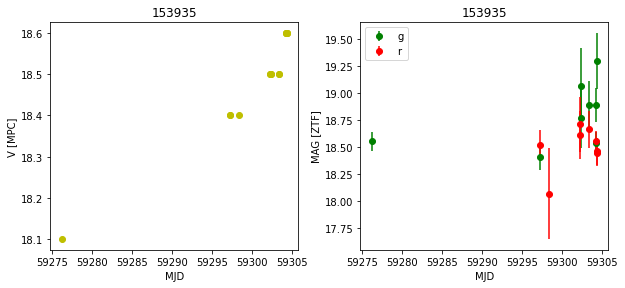

In [29]:
# Just how we got oids, we can get MPC's magnitudes
#Vmpc = ss.loc[ss.oid.isin(oids)].ssmagnr.values
Vmpc = ss.loc[ss.ssnamenr == bestast].ssmagnr.values

# We extract mjds and magnitudes we got from table 'detection'
t = dets.mjd.values; mags = dets.magap.values; mags_err = dets.sigmagap.values
# ZTF observes in two filters: g & r
filters = dets.fid.values; g = filters==1; r = filters==2

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig.subplots_adjust(top=0.96, bottom=.17, hspace=0.05, wspace=0.25)

ax[0].scatter(t, Vmpc, color='y')
ax[0].set_title(bestast); ax[0].set_xlabel("MJD"); ax[0].set_ylabel("V [MPC]")

ax[1].errorbar(t[g], mags[g], yerr=mags_err[g], color='g', label='g', fmt='o')
ax[1].errorbar(t[r], mags[r], yerr=mags_err[r], color='r', label='r', fmt='o')
ax[1].set_title(bestast); ax[1].set_xlabel("MJD"); ax[1].set_ylabel("MAG [ZTF]")
ax[1].legend(loc="upper left")

plt.show()

# Show the image stamps of *153935*

If you want to do your own photometry or your own image subtraction or get some morphological characterization (important for comets), do some visual inspection or just a nice gif, you may want to acces the stamps of your candidates.

To get the stamps, you need to use the `client` of `Alerce`.

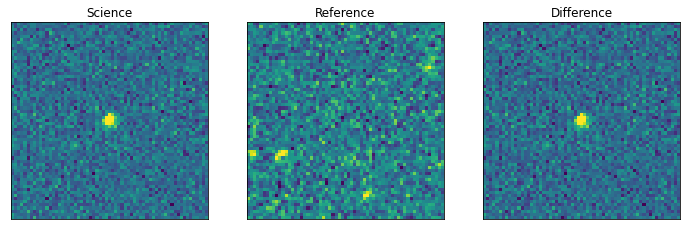

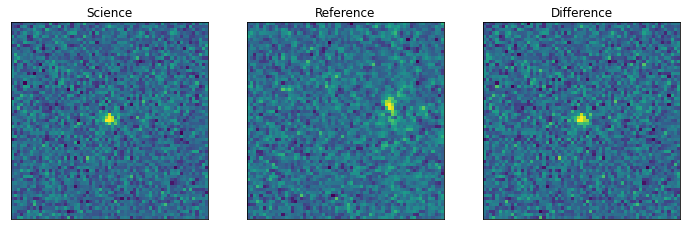

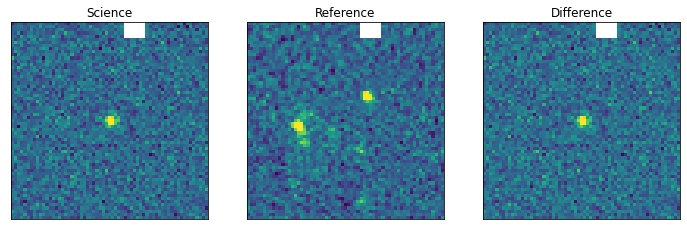

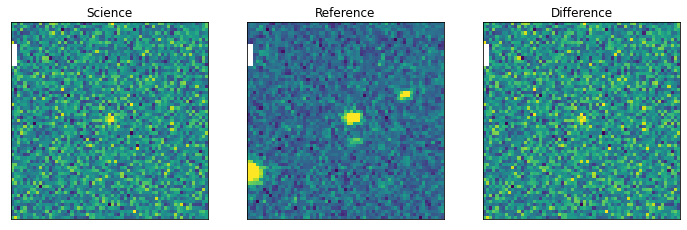

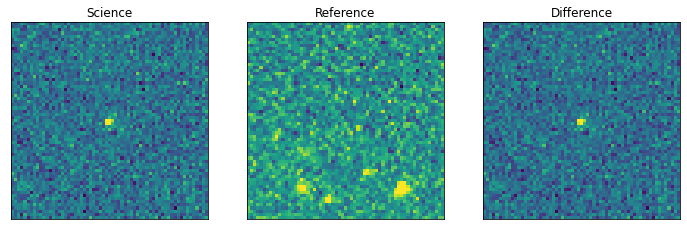

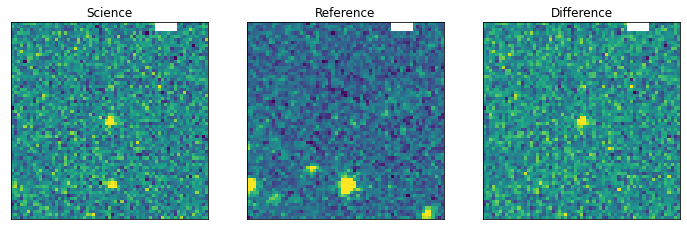

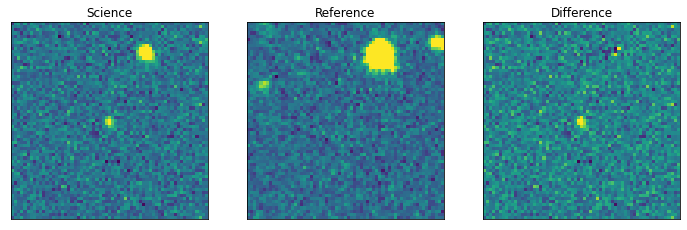

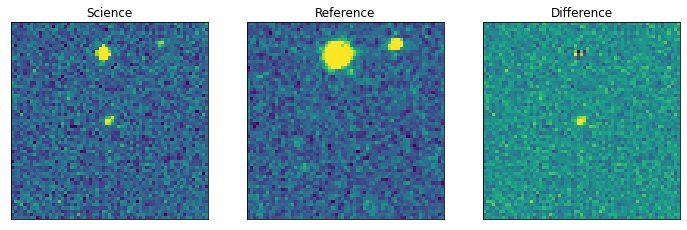

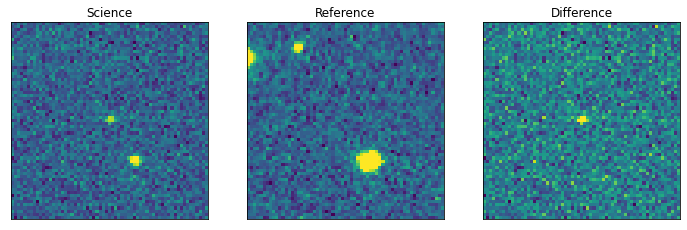

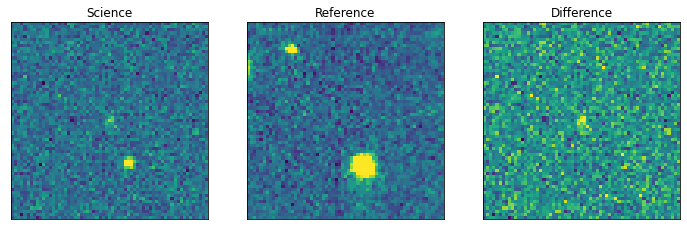

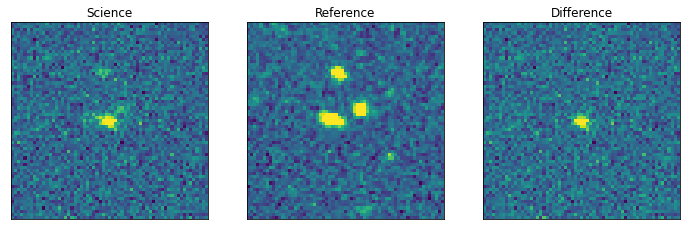

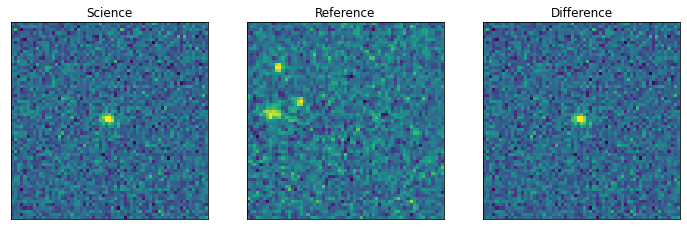

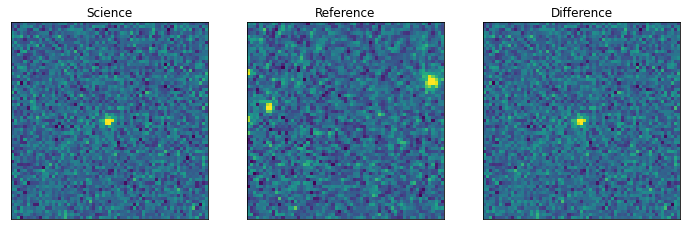

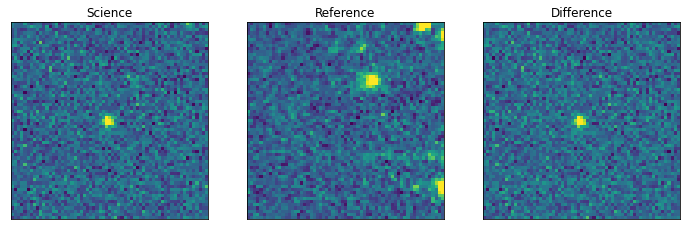

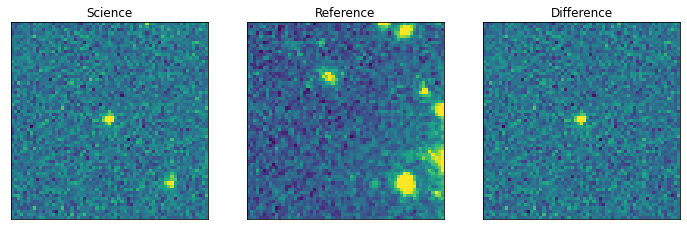

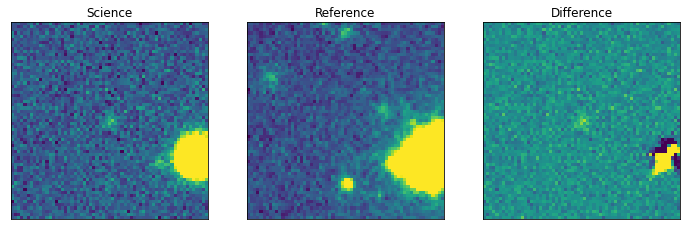

In [30]:
import sys
from astropy.visualization import ZScaleInterval, ImageNormalize

for oid in oids:
    try:
        stamps = client.get_stamps(oid) # get_stamps(oid) returns three fits-like images
        if stamps is None:
          print("Could not find stamp for object id %s" % oid)
          continue
        
        fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        titles = ['Science', 'Reference', 'Difference']
        for idx, im in enumerate([science, ref, difference]):
            norm = ImageNormalize(im, interval=ZScaleInterval()) 
            ax[idx].imshow(im, cmap='viridis', norm=norm, interpolation='nearest') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False); ax[idx].axes.get_yaxis().set_visible(False)
            ax[idx].set_title(titles[idx])
        plt.show()
    except: print("%s ERROR:" %oid, sys.exc_info())

# Get entire light curve for this object

In [35]:
query='''
SELECT *
FROM ss_ztf
WHERE 
ssnamenr = '%s'
''' % bestast

selast = pd.read_sql_query(query, conn)
selast.set_index("candid", inplace=True)
print(selast.shape)
selast.head()

(62, 4)


,oid,ssdistnr,ssmagnr,ssnamenr
candid,,,,
1494462771215015007,ZTF21aagtiae,0.0,18.6,153935
1494421411215015006,ZTF21aagsiea,0.0,18.6,153935
1496368611215015002,ZTF21aahdsgn,0.0,18.6,153935
1502420193015015006,ZTF21aakhuau,0.0,18.5,153935
1496378771215015003,ZTF21aahdxuh,0.0,18.6,153935


The columns in this table are the unique detection identifier `candid`, the unique object identifier `oid`, the distance to the nearest MPC source in arcsec `ssdistnr`, the V magnitude of the nearest MPC source `ssmagnr`, and the name of the nearest MPC soure `ssnamenr`.

Get the magnitudes

In [44]:
query='''
SELECT candid, mjd, fid, magpsf, sigmapsf
FROM detection
WHERE 
candid in (%s)
''' % ",".join(["'%s'" % candid for candid in selast.index])

selast_lc = pd.read_sql_query(query, conn)
selast_lc.set_index("candid", inplace=True)
print(selast_lc.shape)
selast_lc.head()

(62, 4)


,mjd,fid,magpsf,sigmapsf
candid,,,,
1012489376215015017,58766.489375,2,19.916924,0.209309
1037335374215015002,58791.335370,2,20.008413,0.194163
1444476863215015003,59198.476863,2,19.700090,0.156942
1449502094415015002,59203.502095,2,19.509737,0.143729
1449541924415015002,59203.541921,1,19.934290,0.168638


Now we can use the previous magnitudes to get a more complete light curve.

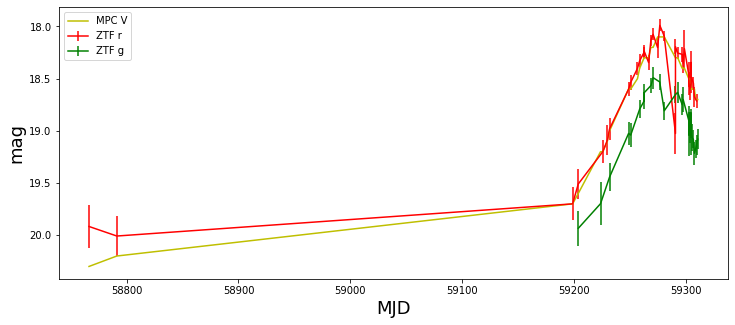

In [71]:
colors = {1: 'g', 2: 'r'}
fig, ax = plt.subplots(figsize=(12,5))
for fid in selast_lc.fid.unique():
  mask = (selast_lc.fid == fid)
  ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf, yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label = "ZTF %s" % colors[fid])
ax.plot(selast_lc.mjd, selast.loc[selast_lc.index].ssmagnr, c='y', label='MPC V')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
ax.legend()

And now we will use the MPC magnitude to look for any deviations.

Text(0, 0.5, '$\\Delta$ mag')

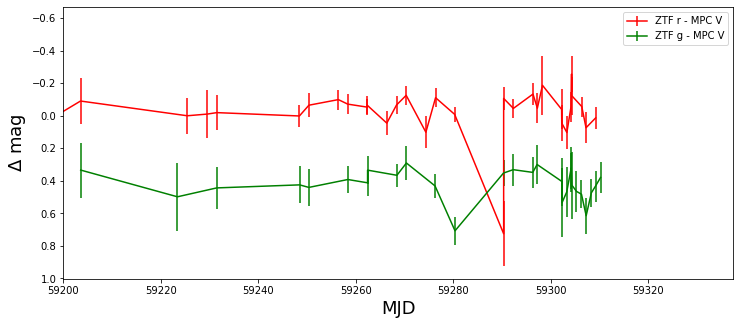

In [72]:
fig, ax = plt.subplots(figsize=(12,5))
for fid in selast_lc.fid.unique():
  mask = (selast_lc.fid == fid)
  ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf - selast.loc[selast_lc.loc[mask].index].ssmagnr,
              yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label='ZTF %s - MPC V' % colors[fid])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(59200,ax.get_xlim()[1])
ax.legend()
ax.set_xlabel("MJD", fontsize=18)
ax.set_ylabel(r"$\Delta$ mag", fontsize=18)

Is that decrease in brightness real?

# Getting the ephemerides

ALEPH: Alerce Ephemerides (under construction, but preview available):

    from aleph_test import Query
    from astropy.coordinates import EarthLocation
    from astropy import units as u

    observer = EarthLocation.of_site('Palomar')
    q = Query.Query()

    ras_aleph = []; decs_aleph = []
    ras = []; decs = []
    for idx in np.where(maskbest)[0]:
        epoch = Time(ast.firstmjd[idx], format='mjd', scale='utc')
        center = SkyCoord(ast.meanra[idx], ast.meandec[idx], unit='deg')
        eph = q.query_nb(center, 1*u.deg, epoch=epoch, observer=observer, ast_idxs=(int(bestast)-1,))
        ras_aleph.append(eph['ra'][0]); decs_aleph.append(eph['dec'][0])
        ras.append(ast.meanra[idx]); decs.append(ast.meandec[idx])
    coords_aleph = SkyCoord(ras_aleph, decs_aleph)
    coords_ztf = SkyCoord(ras, decs, unit='deg')

Although ALEPH is not yet publicly available, we have precomputed the ephemerides for the asteroid with the most detections.

In [74]:
from astropy import units as u
import urllib.request
import pickle

coords_aleph = pickle.load(urllib.request.urlopen("https://github.com/alercebroker/usecases/blob/master/example_data/ephs_153935_20210301-20210402.pkl?raw=true"))
coords_ztf = SkyCoord(ast.loc[maskbest].meanra.values, ast.loc[maskbest].meandec.values, unit='deg')

In [75]:
coords_aleph.separation(coords_ztf).arcsec

array([[1.77286432e+04, 1.77551419e+04, 1.45030641e+04, 2.93660196e-02,
        1.44738909e+04, 1.73746478e+04, 1.77851667e+04, 1.69330132e+04,
        1.73909875e+04, 1.77727498e+04, 1.78030619e+04, 1.69775467e+04,
        1.69756251e+04, 1.77458020e+04, 1.50611209e+04, 1.69453750e+04],
       [3.43068217e+03, 3.45944008e+03, 3.00673293e+01, 1.44738491e+04,
        3.41196137e-01, 3.04673040e+03, 3.49214283e+03, 2.57308013e+03,
        3.06443854e+03, 3.47853503e+03, 3.51163655e+03, 2.62059663e+03,
        2.61855915e+03, 3.44928018e+03, 6.07355899e+02, 2.58621387e+03],
       [3.40069786e+03, 3.42945927e+03, 2.34404326e-01, 1.45030702e+04,
        3.02322919e+01, 3.01669904e+03, 3.46216636e+03, 2.54300465e+03,
        3.03440934e+03, 3.44855651e+03, 3.48166266e+03, 2.59052494e+03,
        2.58848733e+03, 3.41929807e+03, 5.77200535e+02, 2.55613927e+03],
       [2.82652810e+03, 2.85535528e+03, 5.77373587e+02, 1.50612560e+04,
        6.07511352e+02, 2.44164092e+03, 2.88814420e+03, 1.967

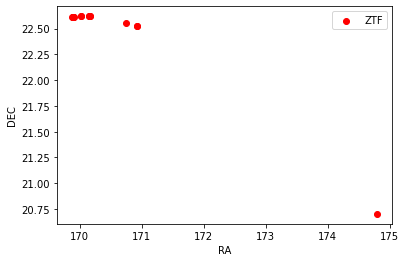

In [76]:
plt.scatter(coords_ztf.ra.deg, coords_ztf.dec.deg, color='r', label="ZTF")
#plt.scatter(coords_aleph.ra.deg, coords_aleph.dec.deg, color='k', marker='+', label="ALEPH")
plt.xlabel("RA")
plt.ylabel('DEC')
plt.legend()

# ALEPH vs. Public Services

We now show the distribution of distances between the observed coordinates and those computed by the MPC, the IMCCE, and ALEPH. 

* MPC: https://minorplanetcenter.net/cgi-bin/checkmp.cgi (it only allows time precision of 0.01 days)
* IMCCE: http://vo.imcce.fr/webservices/miriade/?ephemph and Python's `astroquery.imcce.Skybot`

<img src="https://raw.githubusercontent.com/alercebroker/usecases/master/notebooks/colab/figures/dists_contours.png">

IMCCE and ALEPH's ephemerides consider the gravitational pull from the Sun and the planets (plus Pluto). ALEPH's coordinates are more precise and less biased!
(and calculated in similar times).